config.py

Contains the the list of common stop words which will be filtered out during the preprocess and a list of the URL adresses to the books scraped.

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
STOPWORDS = stopwords.words('english') + ['and']
URL_LIST = ['https://www.gutenberg.org/files/25830/25830-h/25830-h.htm',
            'https://www.gutenberg.org/files/84/84-h/84-h.htm',
            'https://www.gutenberg.org/files/32069/32069-h/32069-h.htm',
            'https://www.gutenberg.org/files/19362/19362-h/19362-h.htm',
            'https://www.gutenberg.org/files/64783/64783-h/64783-h.htm',
            'https://www.gutenberg.org/files/64791/64791-h/64791-h.htm',
            'https://www.gutenberg.org/files/64790/64790-h/64790-h.htm',
            'https://www.gutenberg.org/files/2610/2610-h/2610-h.htm',
            'https://www.gutenberg.org/files/32300/32300-h/32300-h.htm',
            'https://www.gutenberg.org/files/83/83-h/83-h.htm',
            'https://www.gutenberg.org/files/103/103-h/103-h.htm',
            'https://www.gutenberg.org/files/64810/64810-h/64810-h.htm',
            'https://www.gutenberg.org/files/11659/11659-h/11659-h.htm'
            ]

path_management.py

Handles finding and defining the paths used when saving and using the books scraped from gutenberg.org.

In [ ]:
from pathlib import Path
import os


def get_project_root():
    return os.getcwd()


def get_bookname_from_url(url):
    page = url.split('/')[-1]
    name = page.split('.')[0]
    return name


def get_bookfolder():
    root_folder = get_project_root()
    book_folder = os.path.join(root_folder, 'Files', 'Books')
    return book_folder


def get_bookpath(url):
    name = get_bookname_from_url(url)
    book_folder = get_bookfolder()
    bookpath = os.path.join(book_folder, f'{name}.pickle')
    return bookpath


def book_downloaded(url):
    bookpath = get_bookpath(url)
    return os.path.isfile(bookpath)

scrape.py

Contains the functions which use the URL addresses previously defined to scrape the books from gutenberg.org and save the text body as a pickle file and the title as a variable.

In [ ]:
from bs4 import BeautifulSoup
import requests
import pickle
import re


def pickle_result(result):
    book_folder = get_bookfolder()
    bookpath = get_bookpath(result.url)
    Path(book_folder).mkdir(parents=True, exist_ok=True)
    with open(bookpath, 'wb+') as p_file:
        pickle.dump(result, p_file)

    return bookpath


def get_page(url):
    if book_downloaded(url):
        fullpath = get_bookpath(url)
    else:
        result = requests.get(url)
        if result.status_code == 200:
            fullpath = pickle_result(result)
        else:
            raise Exception(f'Request error code: {result.status_code}')

    return fullpath


def load_page(full_path):
    with open(full_path, 'rb') as p_file:
        unpickled_page = pickle.load(p_file)

    return BeautifulSoup(unpickled_page.text, 'html.parser')


def trim_page(soup, identifiers):
    for element in soup.find_all(*identifiers):
        element.decompose()


def filter_page(soup):
    removal = True
    for i, element in enumerate(soup.body.find_all()):
        if '*** START' in element.text:
            element.decompose()
            removal = False
        elif '*** END' in element.text:
            removal = True

        if removal:
            element.decompose()


def get_title(soup):
    paragraphs = soup.body.find_all()
    for p in paragraphs:
        if '*** START' in p.text:
            title = p.text
            title = title.strip()
            title = title.encode('ascii', 'ignore').decode()
            title = re.sub('\r', '', title)
            title = re.sub('\n', ' ', title)

            regex = re.compile('(\*{3}[^\*]*\*{3})')
            match_obj = regex.search(title)
            if match_obj:
                title = match_obj[0]

            title = re.sub('\*{3} START OF (THIS|THE) PROJECT GUTENBERG EBOOK ', '', title)
            title = title.replace('***', '').strip().title()
            return title


def scrape_url(url):
    full_path = get_page(url)
    soup = load_page(full_path)
    title = get_title(soup)
    filter_page(soup)
    text_list = soup.body.get_text(separator="\n", strip=True).split()
    book_dict = {'title': title,
                 'text_list': text_list}
    return book_dict


preprocess.py

Contains all methods used to format and clean the text to and transform it from a binary text to a list containing only terms useful to the algorithm.

In [ ]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')



def stemmer(text_list):
    new_text_list = []
    ps = PorterStemmer()

    for text in text_list:
        stemmed_text = ps.stem(text)
        new_text_list.append(stemmed_text)
        if text != stemmed_text:
            #print(text + "->" + stemmed_text)
            pass
    return new_text_list


def lemmatize(text_list):
    new_text_list = []
    lemmatizer = WordNetLemmatizer()
    for text in text_list:
        lemmed_text = lemmatizer.lemmatize(text)
        new_text_list.append(lemmed_text)
        if text != lemmed_text:
            # print(text + "->" + lemmed_text)
            pass

    return new_text_list


def remove_encoding(text_list):
    text_list = [text.encode('ascii', 'ignore').decode() for text in text_list]
    return text_list


def remove_symbols(text_list):  # TODO: maybe exculde apostrophes and make separate method?
    text_list = [re.sub('[^a-zA-Z0-9 ]', '', text).strip() for text in text_list]
    return text_list


def remove_singel_characters(text_list):
    return [text for text in text_list if len(text) > 1]


def remove_empty_strings(text_list):
    return [text for text in text_list if text]


def text_list_to_lower(text_list):
    return [text.lower() for text in text_list]


def remove_stop_words(text_list):
    return [term for term in text_list if term not in STOPWORDS]


def clean_text(text_list):
    text_list = remove_encoding(text_list)
    text_list = text_list_to_lower(text_list)
    text_list = remove_stop_words(text_list)
    text_list = remove_symbols(text_list)
    text_list = remove_singel_characters(text_list)
    text_list = lemmatize(text_list)
    text_list = stemmer(text_list)
    text_list = remove_singel_characters(text_list)
    return text_list

book.py

Contains the Book and BookHandler classes which are used to hold all information and statistics related to the books. Within the classes are the methods used to calculate tf-idf score and compare books to each other with both matching score and cosine similarity.

In [ ]:
import math
import random


class Book:
    def __init__(self, title, text_list):
        self.title = title
        self.text = text_list
        self.clean()
        self.word_dict = self._word_count()
        self.tfidf = None
        self.vector = None

    def clean(self):
        self.text = clean_text(self.text)

    def calc_tf(self, word):
        return self.word_dict[word] / len(self.text)

    def vectorize(self, vocab):
        vector = []
        for word in vocab:
            if word in self.tfidf:
                value = self.tfidf[word]
            else:
                value = 0

            vector.append(value)

        self.vector = vector

    def cosinus_similarity(self, other_book):
        dot_product = sum([self.vector[i] * other_book.vector[i] for i, _ in enumerate(self.vector)])
        abs_first = sum([num**2 for num in self.vector])**0.5
        abs_second = sum([num**2 for num in other_book.vector])**0.5
        cos_angle = dot_product / (abs_first * abs_second)
        cos_angle = 1 if cos_angle > 1 else cos_angle
        return math.acos(cos_angle)

    def _word_count(self):
        term_dict = {}
        for term in self.text:
            if term in term_dict:
                term_dict[term] += 1
            else:
                term_dict[term] = 1

        return term_dict


class BookHandler:
    def __init__(self):
        self.books = []

    def add(self, book):
        self.books.append(book)

    def remove(self, book):
        self.books.remove(book)

    def calc_tfidf(self):
        for book in self.books:
            tf_idf_dict = {}
            for term in book.word_dict:
                tf_score = book.calc_tf(term)
                idf_score = self.calc_idf(term)
                tf_idf = tf_score * idf_score
                tf_idf_dict[term] = tf_idf

            book.tfidf = tf_idf_dict

    def calc_idf(self, word):
        total_documents = len(self.books)
        docs_with_term = len([book for book in self.books if word in book.word_dict])
        return math.log((total_documents) / (docs_with_term))

    def matching_score(self, query_book):
        m_scores = [{'book': b, 'score': 0} for b in self.books]

        for word in query_book.word_dict:
            for i, book in enumerate(self.books):
                if word in book.word_dict:
                    m_scores[i]['score'] += book.tfidf[word]

        m_scores = sorted(m_scores, key=lambda x: x['score'], reverse=True)
        return m_scores

    def get_total_vocab(self):
        total_vocab = []
        for book in self.books:
            total_vocab += list(book.word_dict.keys())

        return total_vocab

    def recommend_book(self, query_book):
        self.calc_tfidf()
        m_scores = self.matching_score(query_book)
        self.add(query_book)
        self.calc_tfidf()
        vocab = self.get_total_vocab()
        query_book.vectorize(vocab)
        self.remove(query_book)

        angles = []

        for book in self.books:
            book.vectorize(vocab)
            angle = book.cosinus_similarity(query_book)
            angles.append({'angle': angle, 'book': book})

        sorted_angles = sorted(angles, key=lambda x: x['angle'])
        return {
            'matching_score': m_scores,
            'cosinus_similarity': sorted_angles
        }


def main():
    book_handler = BookHandler()
    # query_book_index = 6
    # query_book_url = URL_LIST[query_book_index]
    query_book_url = random.choice(URL_LIST)
    URL_LIST.remove(query_book_url)
    for url in URL_LIST:
        book_dict = scrape_url(url)
        book = Book(book_dict['title'], book_dict['text_list'])
        book_handler.add(book)

    query_book_dict = scrape_url(query_book_url)
    query_book = Book(query_book_dict['title'], query_book_dict['text_list'])
    result = book_handler.recommend_book(query_book)
    print('Querybook')
    print(f'Title: {query_book.title}')
    print('-' * 30)
    print('Compared books')
    print('\n'.join([f'Title: {book.title}' for book in book_handler.books]))
    print('-' * 30)
    print(f'The recommended books for ({query_book.title}) are:')
    matching_score = result['matching_score']
    cosinus_similarity = result['cosinus_similarity']

    print('By Matching Score:')
    for i, score in enumerate(matching_score):
        book = score['book']
        score = score['score']
        print(f'{i+1}: {book.title}, ({score})')

    print('-' * 30)
    print('By Cosine Similarity:')
    for i, angle in enumerate(cosinus_similarity):
        book = angle['book']
        angle = angle['angle']
        print(f'{i+1}: {book.title}, ({math.degrees(angle)})')


if __name__ == '__main__':
    main()


# Frågeställningar

Vad är TF-IDF?
Vad är det för matematik bakom TF-IDF?
Hur fungerar TF-IDF i praktiken?
Vilka fördelar finns?
Vilka är de stora nackdelarna?

# TF-IDF

TF-IDF är en frekvensbaserad metod för att vektorisera text. Icke frekvensbaserade metoder kan vara förutsägelsebaserade metoder som exempelvis Continuous Bag Of Words (CBOW). Förutsägelsebaserade metoder tittar på sammanhanget i vilket ett ord förekommer och beräknar troligheten av att ett ord ska förekomma i samma sammanhang som ett annat ord. Att TF- IDF är frekvensbaserad innebär helt enkelt att den räknar förekomsten, frekvensen av ord i dokument. Men till skillnad från exempelvis Bag of words (alltså inte CBOW) så säger TF-IDF något om hur viktiga orden är i ett dokument och även i förhållande till hur viktiga de orden är i andra dokument. Algoritmen tilldelar termer en vikt beroende av hur ofta ett ord förekommer i en vald text kontra om det förekommer för ofta i en större samling med dokument. Dokumentet som man utgår från ger en hög viktning åt de ord som förekommer ofta i just det dokumentet men ju fler dokument som innehåller ordet desto lägre kommer det att viktas. Detta betyder att om ett ord är väldigt vanligt i två av dokumenten men ovanligt i den totala samlingen kommer det att viktas som väldigt relevant. För att göra användningen av TF-IDF så precis som möjligt så krävs det att man “tvättar” texterna innan man räknar på orden. Man tar bort s.k. stoppord, gör om orden till sin grundform och tar bort ändelser, prefix och andra tecken än bokstäver. Man kan även bestämma ordens ordformer för att mer effektivt kunna böja om dem till sin grundform men just detta hoppade vi över i vårt program för att spara tid.


# Matematik

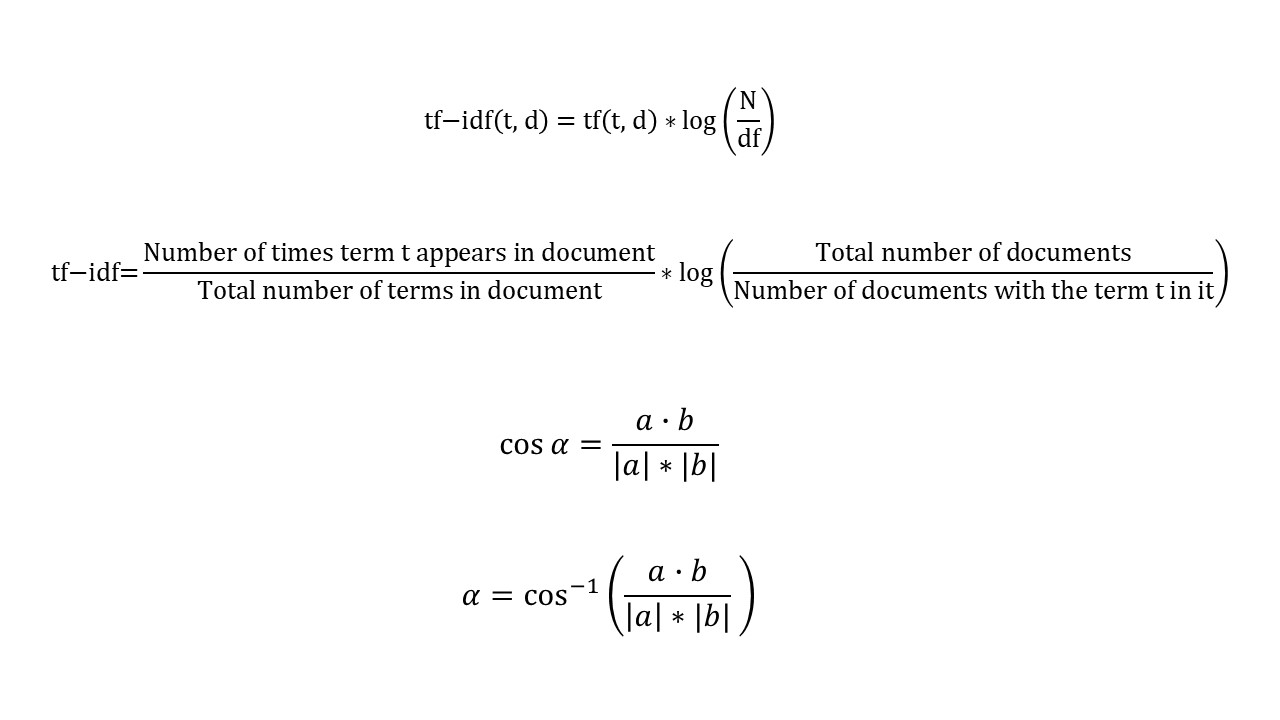

# Praktisk användning

En användning kan vara ett program som använder sig av tf-idf-värden för att jämföra ett dokument mot andra dokument i en datauppsättning. Talen som ges för varje term av algoritmen kan sedan användas i en matchnings-beräkning för att avgöra hur relevant vardera dokument är. Detta används framför allt i sökfunktioner. En metod som vi har använt för att jämföra dokumentets td-idf-värden är att helt enkelt slå ihop tf-idf-värdet av de ord som förekommer i ett dokument och som också förekommer i ett dokument som man vill jämföra med. Ett dokuments relevans bedöms alltså utifrån de samlade TF-IDF-poäng som dokumentets ord adderats ihop till. Ett annat exempel på metod för att jämföra tf-idf-värden är cosinuslikhet och det är den andra metoden som vi har använt. Cosinuslikhetsmetoden går ut på att se hur stor vinkeln är mellan de vektoriserade termerna i ett dokument och en samling andra dokument. Ju lägre vinkel, desto större likhet finns mellan de ord som bedöms som viktiga i ett dokument och de ord som bedöms som viktiga i ett annat.

# Fördelar med TF-IDF

TF-IDF är en i jämförelse enkel metod som inte kräver neurala nätverk eller dylikt. TF-IDF tar i beaktning om termer är så pass vanliga att de är irrelevanta.


# Nackdelar med TF-IDF

Att samla den data som krävs för algoritmen, snabb beräkningshastighet behövs i förtid samlad data. TF-IDF kräver mycket internminne på grund av att det är mycket data som ska lagras på en gång om man tittar på många dokument och många ord. Urvalet av data som matas in och hur den bearbetas innan kan ge väldigt variation av resultat.

# Jämförelser 

I samlingen med böcker som vi använde så fanns det med boken Frankenstein samt en bok som handlar om boken Frankenstein. Dessa böcker var inte helt otippat de böcker som båda metoderna som vi använt klassade som mest lika varandra. Den bok som visade sig vara minst lik de andra böckerna var Mio Figlio. Detta kan komma sig av att den var skriven på italienska och de andra på engelska.


# Källförteckning 

https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

https://sv.qaz.wiki/wiki/Cosine_similarity

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

http://www.gutenberg.org

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

https://www.nltk.org

https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/

https://programmerbackpack.com/tf-idf-explained-and-python-implementation/

https://medium.datadriveninvestor.com/tf-idf-for-similarity-scores-391c3c8788e8

